In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [4]:
# csv_path = "../../results/domain_shift_linear.csv"
csv_path = "../../results/domain_shift_finetune.csv"

In [5]:
df = pd.read_csv(csv_path, index_col=0)

In [6]:
df

,UCF101,NTU60,SSv2,Gym99,EPIC (V)
None,75.36,92.87,56.81,89.41,25.67
SeLaVi,84.88,92.78,56.37,88.93,33.77
RSPNet,88.47,93.90,59.39,91.28,42.67
VideoMoCo,85.83,94.09,58.75,90.54,43.61
Pretext-contrast,86.60,93.86,54.03,90.31,34.29
CTP,89.77,94.31,60.16,92.17,42.84
TCLR,90.77,94.11,59.64,91.49,36.18
GDT,91.14,93.89,57.78,90.36,37.26
AVID-CMA,89.33,93.99,53.82,90.56,29.91
Supervised,94.08,93.89,61.02,91.77,47.67


In [7]:
# df.columns = [["UCF101", "NTU", "Something-something", "FineGym", "EPIC (Verb)"]]

In [8]:
df

,UCF101,NTU60,SSv2,Gym99,EPIC (V)
None,75.36,92.87,56.81,89.41,25.67
SeLaVi,84.88,92.78,56.37,88.93,33.77
RSPNet,88.47,93.90,59.39,91.28,42.67
VideoMoCo,85.83,94.09,58.75,90.54,43.61
Pretext-contrast,86.60,93.86,54.03,90.31,34.29
CTP,89.77,94.31,60.16,92.17,42.84
TCLR,90.77,94.11,59.64,91.49,36.18
GDT,91.14,93.89,57.78,90.36,37.26
AVID-CMA,89.33,93.99,53.82,90.56,29.91
Supervised,94.08,93.89,61.02,91.77,47.67


In [9]:
df.values.argsort(axis=0)

array([[0, 1, 8, 1, 0],
       [1, 0, 4, 0, 8],
       [3, 4, 1, 4, 1],
       [4, 7, 0, 7, 4],
       [2, 9, 7, 3, 6],
       [8, 2, 3, 8, 7],
       [5, 8, 2, 2, 2],
       [6, 3, 6, 6, 5],
       [7, 6, 5, 9, 3],
       [9, 5, 9, 5, 9]])

### Column-wise normalized

In [10]:
norm_df=(df-df.loc["None"])/(df.loc["Supervised"]-df.loc["None"])

In [11]:
def heatmap(
        df,
        figsize=(7, 6),
        title="Action classification",
        titlesize=20,
        labelsize=15,
        tickssize=13,
        save=False,
        save_path="../../results/plots/sample.pdf",
        **kwargs,
    ):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    if "cmap" not in kwargs:
        kwargs.update(dict(cmap="YlGnBu"))
    sns.heatmap(df, ax=ax, **kwargs)

    ax.set_title(title, fontsize=titlesize)

    ax.set_xlabel("Dataset")
    ax.set_ylabel("Method")
    
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)

    ax.tick_params(axis='x', labelsize=tickssize)
    ax.tick_params(axis='y', labelsize=tickssize)
    
    if save:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()

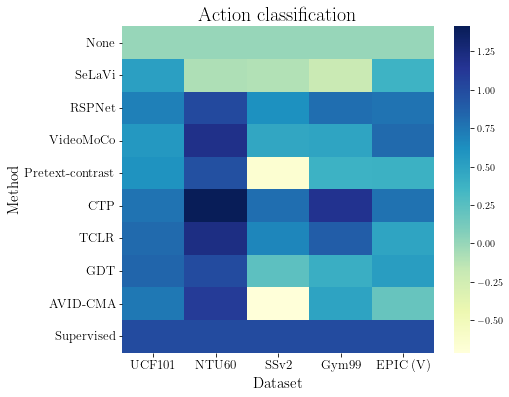

In [12]:
heatmap(norm_df)

### Normalizing between 0-1

In [13]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [14]:
annot = df.values
# annot = (df - df.T["None"]).values

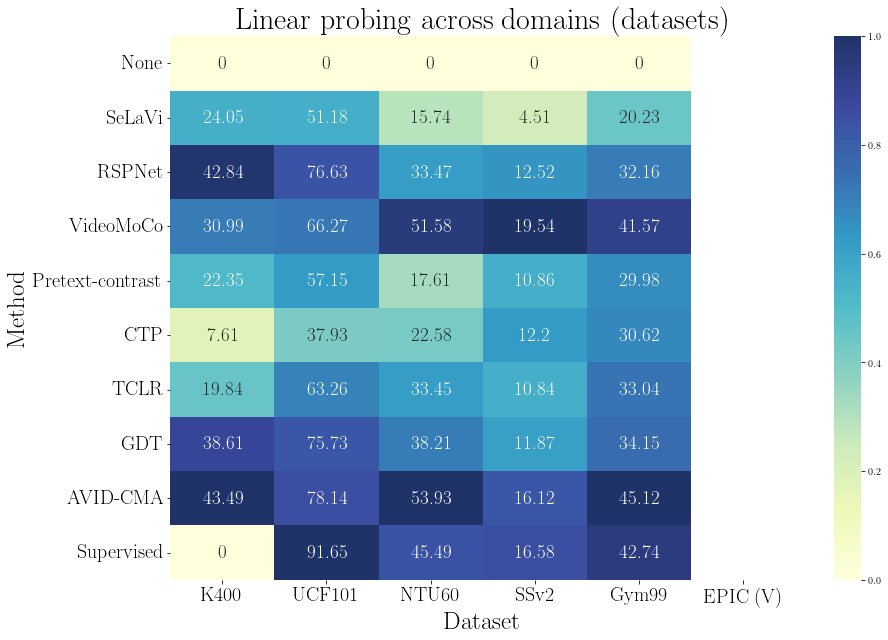

In [19]:
heatmap(
    normalized_df,
    figsize=(14, 10),
    title="Linear probing across domains (datasets)",
    titlesize=30,
    labelsize=25,
    tickssize=20,
    save=True,
    save_path="../../results/plots/domains_expt_linear_annot_absolute.pdf",
    cmap="YlGnBu",
    alpha=0.9,
    annot=annot,
    fmt='g',
    annot_kws={"size": 19},
)

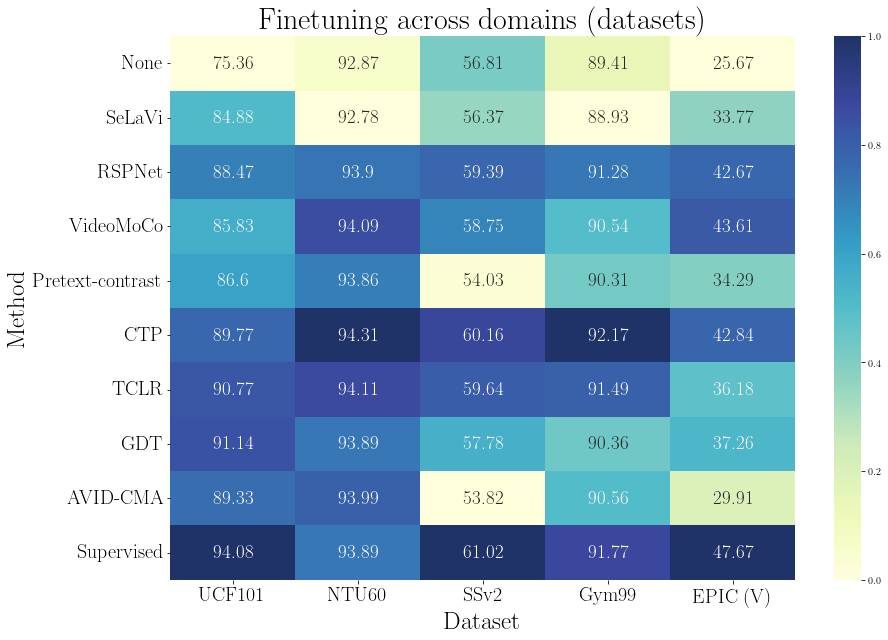

In [15]:
heatmap(
    normalized_df,
    figsize=(14, 10),
    title="Finetuning across domains (datasets)",
    titlesize=30,
    labelsize=25,
    tickssize=20,
    save=True,
    save_path="../../results/plots/domains_expt_finetune_annot_absolute_v2.pdf",
    cmap="YlGnBu",
    alpha=0.9,
    annot=annot,
    fmt='g',
    annot_kws={"size": 19},
)

### Relative improvement w.r.t. scratch

In [42]:
# normalized_df = (df - df.loc["None"]) / (df.loc["None"])
normalized_df = (df - df.loc["None"])
normalized_df /= normalized_df.max()

In [43]:
normalized_df

,UCF101,NTU,Something-something,FineGym,EPIC (Verb)
None,0.000000,0.000000,0.000000,0.000000,0.000000
SeLaVi,0.508547,-0.062500,-0.104513,-0.173913,0.368182
RSPNet,0.546474,0.444444,-0.726841,0.170290,0.479545
VideoMoCo,0.559295,0.847222,0.460808,0.409420,0.815455
Pretext-contrast,0.600427,0.687500,-0.660333,0.326087,0.391818
CTP,0.769765,1.000000,0.795724,1.000000,0.780455
TCLR,0.823184,0.861111,0.672209,0.753623,0.477727
GDT,0.842949,0.708333,0.230404,0.344203,0.526818
Supervised,1.000000,0.708333,1.000000,0.855072,1.000000


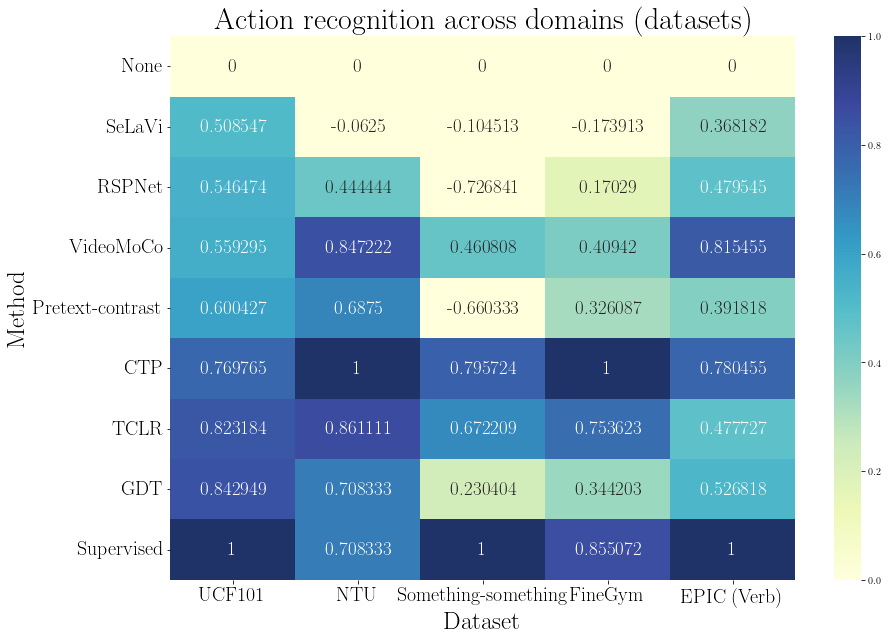

In [44]:
heatmap(
    normalized_df,
    figsize=(14, 10),
    title="Action recognition across domains (datasets)",
    titlesize=30,
    labelsize=25,
    tickssize=20,
    save=True,
    save_path="../../results/plots/domains_expt_2.pdf",
    cmap="YlGnBu",
    alpha=0.9,
    annot=normalized_df.values,
    fmt='g',
    vmin=0.0,
    vmax=1.0,
    annot_kws={"size": 19},
)

### Rank correlation

In [14]:
keys = df.columns

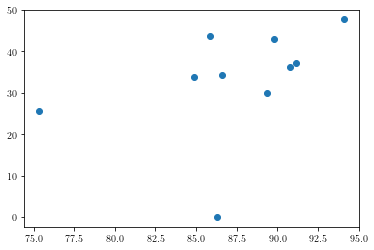

In [15]:
plt.scatter(df["UCF101"].values, df["EPIC (V)"].values)

[]

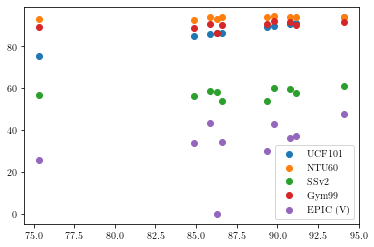

In [16]:
for key in keys:
    plt.scatter(df["UCF101"].values, df[key].values, label=key)
    
plt.legend()
plt.plot()